In [1]:
import os, gc
import glob
import numpy as np
import pandas as pd
import scipy.io as sio

from PIL import Image, ImageSequence

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

#### Curvature fitting
- https://meshlogic.github.io/posts/jupyter/curve-fitting/fitting-a-circle-to-cluster-of-3d-points/

In [2]:
def fit_circle_2d(x, y, w=[]):
    
    A = np.array([x, y, np.ones(len(x))]).T
    b = x**2 + y**2
    
    # Modify A,b for weighted least squares
    if len(w) == len(x):
        W = np.diag(w)
        A = np.dot(W,A)
        b = np.dot(W,b)
    
    # Solve by method of least squares
    c = np.linalg.lstsq(A,b,rcond=None)[0]
    
    # Get circle parameters from solution c
    xc = c[0]/2
    yc = c[1]/2
    r = np.sqrt(c[2] + xc**2 + yc**2)
    return xc, yc, r

def rodrigues_rot(P, n0, n1):
    
    # If P is only 1d array (coords of single point), fix it to be matrix
    if P.ndim == 1:
        P = P[newaxis,:]
    
    # Get vector of rotation k and angle theta
    n0 = n0/np.linalg.norm(n0)
    n1 = n1/np.linalg.norm(n1)
    k = np.cross(n0,n1)
    k = k/np.linalg.norm(k)
    theta = np.arccos(np.dot(n0,n1))
    
    # Compute rotated points
    P_rot = np.zeros((len(P),3))
    for i in range(len(P)):
        P_rot[i] = P[i]*np.cos(theta) + np.cross(k,P[i])*np.sin(theta) + k*np.dot(k,P[i])*(1-np.cos(theta))

    return P_rot

def angle_between(u, v, n=None):
    
    if n is None:
        return np.arctan2(np.linalg.norm(np.cross(u,v)), np.dot(u,v))
    else:
        return np.arctan2(np.dot(n,np.cross(u,v)), np.dot(u,v))
    
def compute_curvature(nbd, traj, num_pts):

    kappa = []

    for pt_idx in range(0, num_pts):

        P = traj[max(0, pt_idx-nbd):min(num_pts, pt_idx+nbd),:]
        P_mean = P.mean(axis=0)
        P_centered = P - P_mean
        U,s,V = np.linalg.svd(P_centered)
        normal = V[2,:]
        d = -np.dot(P_mean, normal) 
        P_xy = rodrigues_rot(P_centered, normal, [0,0,1])
        xc, yc, r = fit_circle_2d(P_xy[:,0], P_xy[:,1])
        kappa.append(1.0/r)
    
    return kappa

#### Plotting

In [3]:
def plot_traj(coords, cvals, color_map):
    
    ax_len = np.max(coords) - np.min(coords)

    fig = plt.figure(figsize=(2.5,2), dpi=300)
    ax = fig.gca(projection='3d')
    p = ax.scatter3D(coords[:,0], coords[:,1], coords[:,2], s=0.1, c=cvals, cmap=color_map)
    ax.quiver(0, 0, 0, 1, 0, 0, length=0.15*ax_len, normalize=True, color="r", lw=0.5, alpha=0.5)
    ax.quiver(0, 0, 0, 0, 1, 0, length=0.15*ax_len, normalize=True, color="g", lw=0.5, alpha=0.5)
    ax.quiver(0, 0, 0, 0, 0, 1, length=0.15*ax_len, normalize=True, color="b", lw=0.5, alpha=0.5)
    plt.axis("off")
    cbar = fig.colorbar(p, fraction=0.03, pad=0.01)
    cbar.ax.tick_params(labelsize=5)
    plt.tight_layout()
    plt.show()

def plot_timelapse(t, coords, seg, n_flashing, flash_mask, embedding_time, embedding_kappa, 
                   save=False, save_path=None):

    im.seek(t)
    
    (w, h) = np.shape(im)
    composite = np.zeros((w,h,3))
    composite[:,:,0] = im/np.max(im)
    composite[:,:,1] = im/np.max(im)
    composite[:,:,2] = im/np.max(im)
    
    seg_px_x = seg[0]
    seg_px_y = seg[1]
    
    for itr in range(len(seg_px_x)):
        if flash_mask[itr]:
            composite[seg_px_y[itr]-1,seg_px_x[itr]-1,0] = 1 
    
    fig = plt.figure(figsize=(15,5), dpi=300)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(composite, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.title("Num. Flashing: " + str(n_flashing))
    
    ax_max = np.max(coords)
    ax_min = np.min(coords)
    ax_len = ax_max - ax_min

    ax = fig.add_subplot(1, 3, 2, projection='3d')
    clr_min = np.min(embedding_time)
    clr_max = np.max(embedding_time)
    p = ax.scatter3D(coords[:t,0], coords[:t,1], coords[:t,2], s=0.1, 
                     c=embedding_time[:t], cmap="coolwarm", vmin=clr_min, vmax=clr_max)
    ax.quiver(0, 0, 0, 1, 0, 0, length=0.15*ax_len, normalize=True, color="r", lw=0.5, alpha=0.5)
    ax.quiver(0, 0, 0, 0, 1, 0, length=0.15*ax_len, normalize=True, color="g", lw=0.5, alpha=0.5)
    ax.quiver(0, 0, 0, 0, 0, 1, length=0.15*ax_len, normalize=True, color="b", lw=0.5, alpha=0.5)
    ax.set_xlim([ax_min, ax_max])
    ax.set_ylim([ax_min, ax_max])
    ax.set_zlim([ax_min, ax_max])
    plt.axis("off")
    cbar = fig.colorbar(p, fraction=0.03, pad=0.01)
    cbar.ax.tick_params(labelsize=5)
    
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    clr_min = np.min(embedding_kappa)
    clr_max = np.max(embedding_kappa)
    p = ax.scatter3D(coords[:t,0], coords[:t,1], coords[:t,2], s=0.1, 
                     c=embedding_kappa[:t], cmap="hot", vmin=clr_min, vmax=clr_max)
    ax.quiver(0, 0, 0, 1, 0, 0, length=0.15*ax_len, normalize=True, color="r", lw=0.5, alpha=0.5)
    ax.quiver(0, 0, 0, 0, 1, 0, length=0.15*ax_len, normalize=True, color="g", lw=0.5, alpha=0.5)
    ax.quiver(0, 0, 0, 0, 0, 1, length=0.15*ax_len, normalize=True, color="b", lw=0.5, alpha=0.5)
    ax.set_xlim([ax_min, ax_max])
    ax.set_ylim([ax_min, ax_max])
    ax.set_zlim([ax_min, ax_max])
    plt.axis("off")
    cbar = fig.colorbar(p, fraction=0.03, pad=0.01)
    cbar.ax.tick_params(labelsize=5)

    if save == True:
        plt.tight_layout()
        plt.savefig(os.path.join(save_path, str(t).zfill(4)+".png"))
        plt.close(fig)
        fig.clf()
    else:
        plt.show()

#### Load data

In [4]:
parent_dir = "/mnt/storage_volume/data/Greco_Ca_Analysis"

phate_traj_path = os.path.join(parent_dir, 
                    "mmc_phate_all_hyperstack_190105_16-36-21_green_900frames_ALL_CELLS_plus.mat.npy")
tiff_path = os.path.join(parent_dir, 
                    "hyperstack_190105_16-36-21_green_900frames.tif")
dat_path = os.path.join(parent_dir, 
                    "hyperstack_190105_16-36-21_green_900frames_ALL_CELLS_plus.mat")

In [5]:
# Load trajectories
traj = np.load(phate_traj_path)
num_pts = np.shape(traj)[0]

# Load multipage tiff
im = Image.open(tiff_path)

# Load mat file
seg_data = sio.loadmat(dat_path)

/home/labmember/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/io/matlab/mio.py:218: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


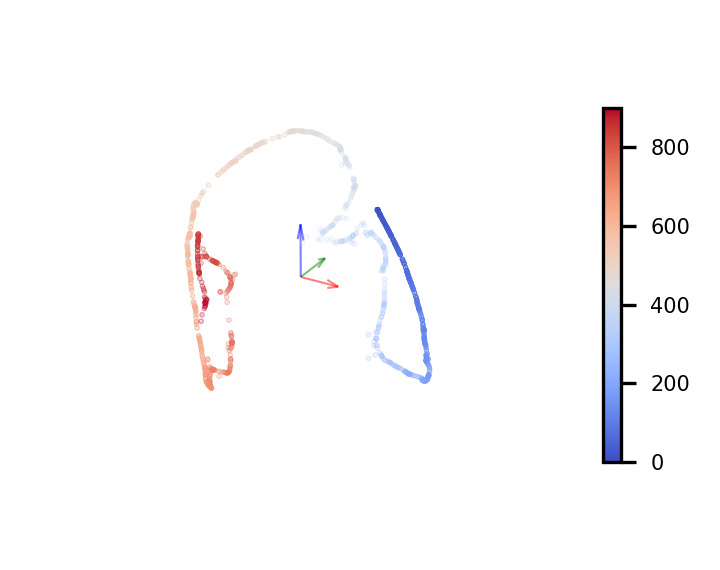

In [6]:
plot_traj(traj, np.arange(num_pts), "coolwarm")

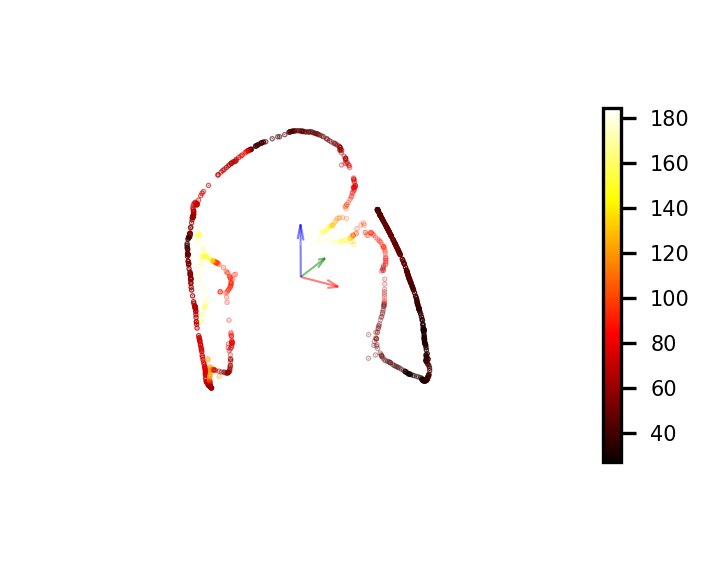

In [7]:
kappa = compute_curvature(50, traj, num_pts)
plot_traj(traj, kappa, "hot")

#### Save Movie

In [8]:
output_dir = os.path.join(parent_dir, "timelapse_movie")
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

In [9]:
totT = seg_data['cells_mean'].shape[0]

for t in range(800, totT):

    seg_px_x = []
    seg_px_y = []
    is_flash = []

    n_flashing = 0
    for cid in range(len(seg_data['cell_per'])):

        num_px = len(seg_data['cell_per'][cid][0])
        is_flashing = False

        for px in range(num_px):

            seg_px_x.append(seg_data['cell_per'][cid][0][px][0])
            seg_px_y.append(seg_data['cell_per'][cid][0][px][1])

            if seg_data['deltaf_ft'][cid, t] > seg_data['threshold'][0][0]:
                is_flash.append(True)
                is_flashing = True
            else:
                is_flash.append(False)
        if is_flashing:
            n_flashing += 1

    plot_timelapse(t, traj, (seg_px_x, seg_px_y), n_flashing, is_flash, np.arange(num_pts), kappa, 
                   save=True, save_path=output_dir)
    
    gc.collect()

In [10]:
seg_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'A_in', 'A_or', 'CC', 'CC2', 'None', 'Z', 'adjacencymatrix', 'areaList', 'areas', 'avg', 'avg_area', 'bins', 'bins3', 'bins4', 'bkg', 'cell_number', 'cell_per', 'cells', 'cells_mean', 'corrThresh', 'cutName', 'd1', 'd2', 'deltaf_f', 'deltaf_ft', 'distances', 'eventDownstream', 'events_info', 'f_f0t_flashing', 'f_f0t_nonflashing', 'fileName', 'fitfun', 'flashingcells', 'nbList', 'nonflashingcells', 'npil_mean', 'numbers', 'overallEvents', 'pid', 'pixelLengthX', 'pixelLengthY', 'pixel_total', 'prog', 'threshT', 'threshTe', 'threshold', 'tid', 'updatedEvents', 'xdata', '__function_workspace__'])

#### TODO:

- Replace `seg_data['cells_mean']` with `seg_data['eventDownstream']` or combination of `seg_data['f_f0t_flashing']` and `seg_data['flashingcells']`

- Plot network of centroids connected by edges. Centroids tbd from cell binary mask (unweighted), and edges from `NbdList`